# Лабораторная работа по вейвлет-преобразованиям

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
import pywt
wavelet = pywt.Wavelet('haar')
print(wavelet)

Wavelet haar
  Family name:    Haar
  Short name:     haar
  Filters length: 2
  Orthogonal:     True
  Biorthogonal:   True
  Symmetry:       asymmetric
  DWT:            True
  CWT:            False


In [3]:
wavelet.filter_bank

([0.7071067811865476, 0.7071067811865476],
 [-0.7071067811865476, 0.7071067811865476],
 [0.7071067811865476, 0.7071067811865476],
 [0.7071067811865476, -0.7071067811865476])

## В задании сказали Добеши второго порядка, но википедия и документация говорит , что это тот же Хаар,  поэтому я взяла четвертый

In [4]:
wavelet = pywt.Wavelet('db2')
print(wavelet)

Wavelet db2
  Family name:    Daubechies
  Short name:     db
  Filters length: 4
  Orthogonal:     True
  Biorthogonal:   True
  Symmetry:       asymmetric
  DWT:            True
  CWT:            False


In [5]:
wavelet.filter_bank

([-0.12940952255126037,
  0.2241438680420134,
  0.8365163037378079,
  0.48296291314453416],
 [-0.48296291314453416,
  0.8365163037378079,
  -0.2241438680420134,
  -0.12940952255126037],
 [0.48296291314453416,
  0.8365163037378079,
  0.2241438680420134,
  -0.12940952255126037],
 [-0.12940952255126037,
  -0.2241438680420134,
  0.8365163037378079,
  -0.48296291314453416])

# Рабочие функции

In [23]:
def image_normalization(src_img):
    norm_img = (src_img - np.min(src_img)) / (np.max(src_img) - np.min(src_img))
    return norm_img

def merge_images(cA, cH_V_D): 
    cH, cV, cD = cH_V_D
    cH = image_normalization(cH) 
    cV = image_normalization(cV) 
    cD = image_normalization(cD) 
    cA = cA[0:cH.shape[0], 0:cV.shape[1]] 
    return np.vstack((np.hstack((cA,cH)), np.hstack((cV, cD))))

def coeffs_visualization(cof):
    norm_cof0 = cof[0]
    norm_cof0 = image_normalization(norm_cof0) 
    merge = norm_cof0
    
    for i in range(1, len(cof)):
        merge = merge_images(merge, cof[i])  
      
    fig, axs = plt.subplots(2, 1, figsize=(8, 16))
    print("2 - Нулевой коэффициент")
    axs[0].imshow(cof[0],cmap=plt.get_cmap('gray'))
    print("3 - Все коэффициенты")
    axs[1].imshow(merge,cmap=plt.get_cmap('gray'))
    
def wavelet_transform_for_image(src_image, level, M_WAVELET="haar", mode="sym"):
    data = src_image.astype(np.float64)
    coeffs = pywt.wavedec2(data, M_WAVELET, level=level, mode=mode)
    return coeffs

In [24]:
def processing(im , WAVELET):

        LEVEL = 4

        im = cv2.resize(im,(512,512))

        print ("1 - Нормированный оригинал")
        plt.imshow(im,cmap=plt.get_cmap('gray'))

        coeffs= wavelet_transform_for_image(im , LEVEL, M_WAVELET=WAVELET)
        coeffs_visualization(coeffs)
        return coeffs

# Исходная картинка 

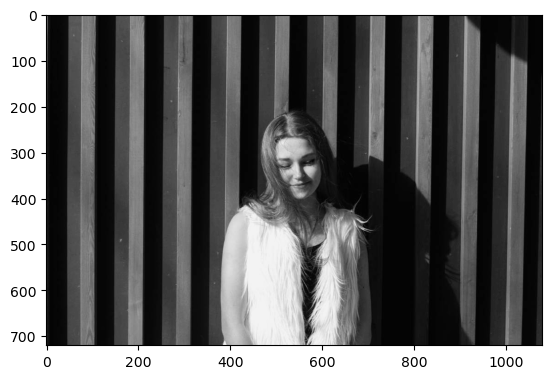

In [18]:
from IPython.display import Image 
pil_img = cv2.imread(filename='masha.jpg')
pil_img = cv2.cvtColor(pil_img, cv2.COLOR_BGR2RGB)
pil_img = cv2.cvtColor(pil_img, cv2.COLOR_RGB2GRAY)

plt.imshow(pil_img,cmap=plt.get_cmap('gray'))

# Преобразовываем :

1 - Нормированный оригинал
2 - Нулевой коэффициент
3 - Все коэффициенты


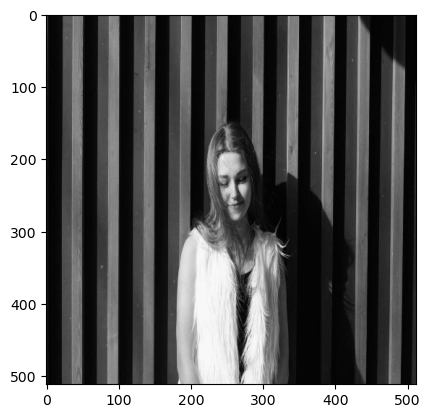

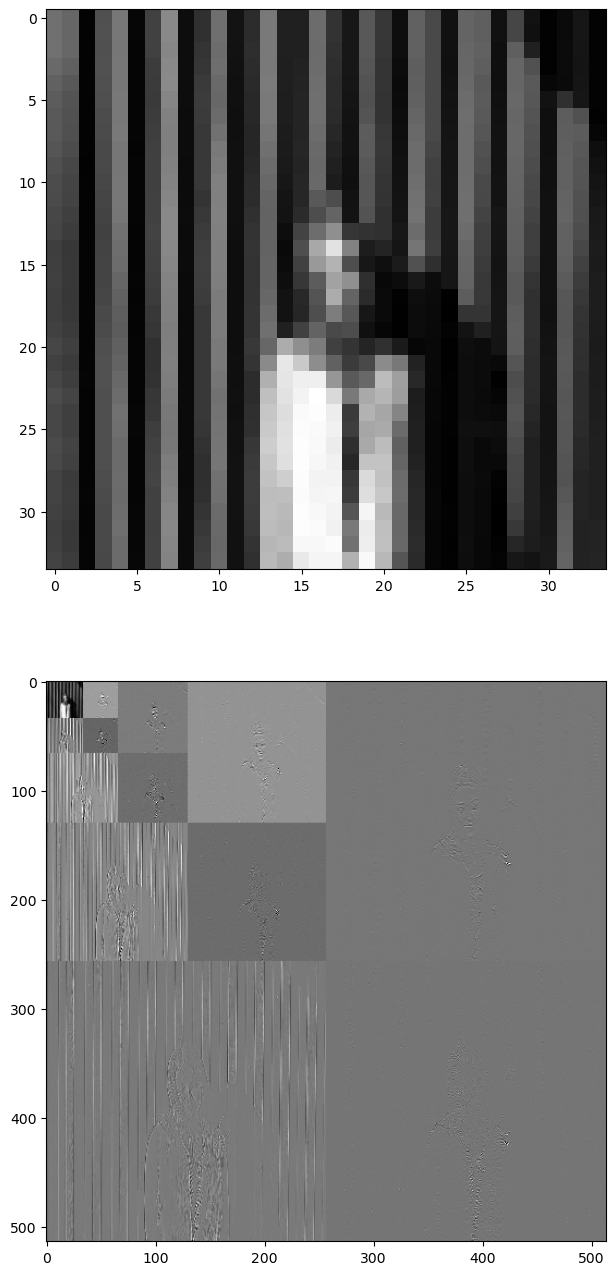

In [25]:
im = pil_img
coeffs = processing (im , 'db2')

# Контуры остались в высокочастотных составляющих (горизонтальное и вертикальное ) :

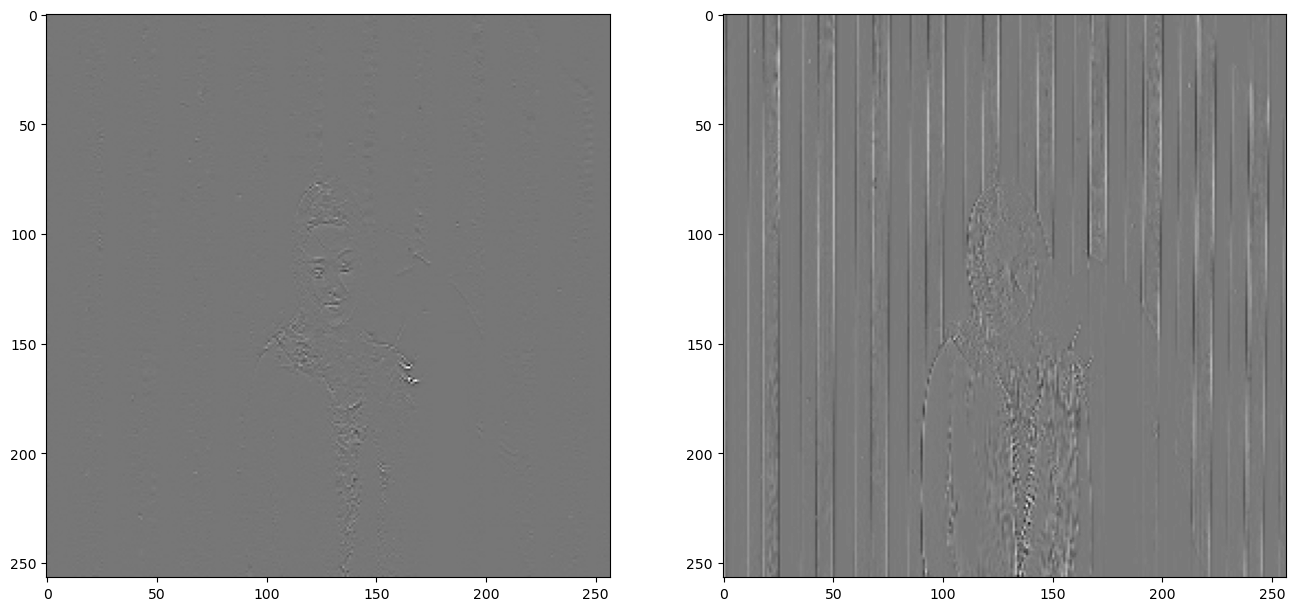

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].imshow(coeffs[4][0],cmap=plt.get_cmap('gray'))
axs[1].imshow(coeffs[4][1],cmap=plt.get_cmap('gray'))

# Теперь восстановим без высоких частот

In [27]:
G = pywt.waverec2(coeffs[:4], 'db2')

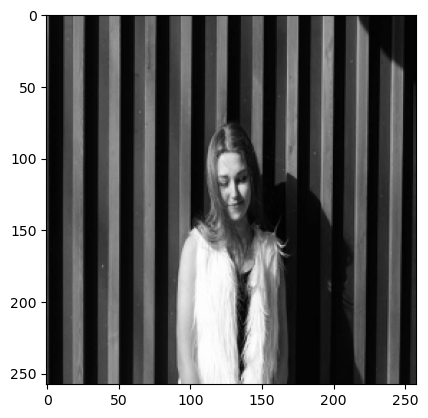

In [28]:
plt.imshow(G,cmap=plt.get_cmap('gray'))

# Результат отличный , теперь Хаар

1 - Нормированный оригинал
2 - Нулевой коэффициент
3 - Все коэффициенты


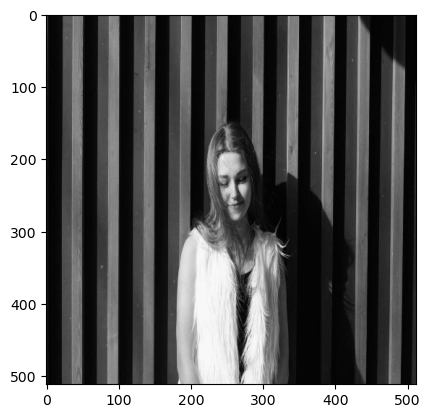

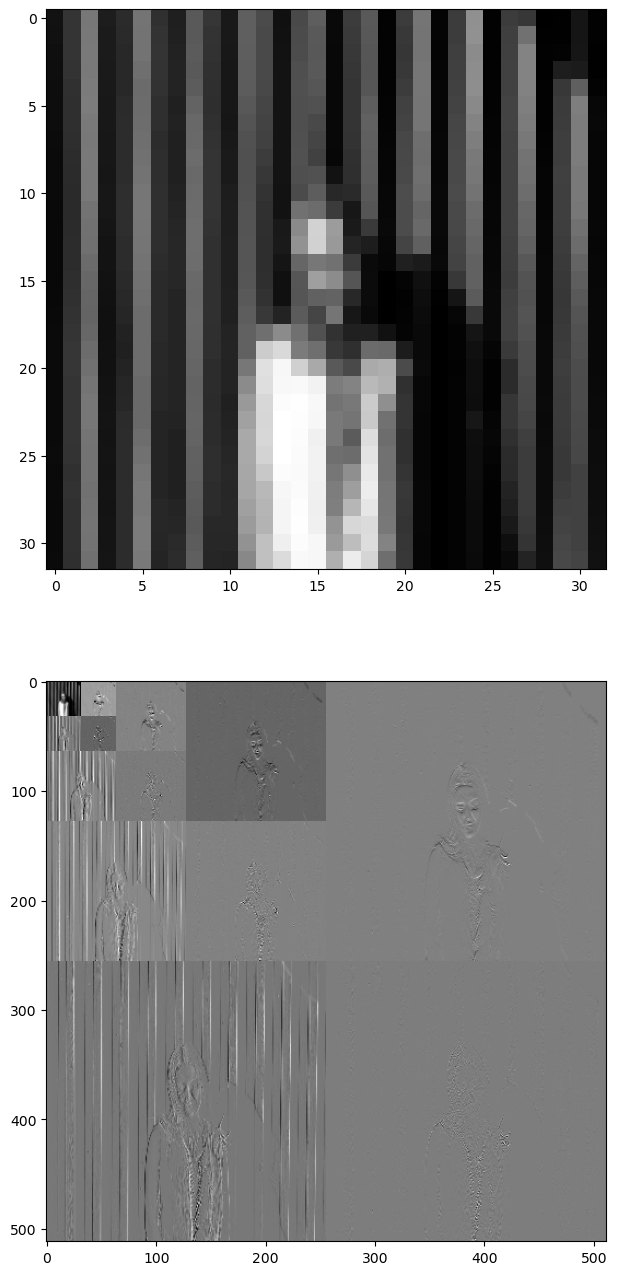

In [29]:
coeffs = processing (im , 'haar')

In [30]:
G = pywt.waverec2(coeffs[:4], 'haar')

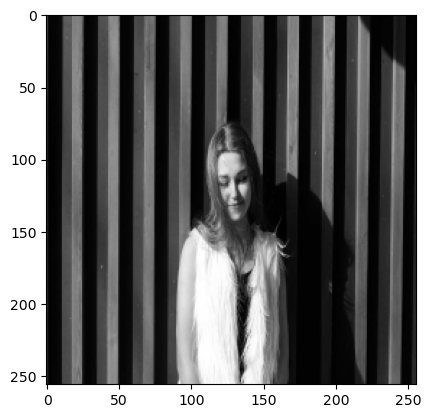

In [31]:
plt.imshow(G,cmap=plt.get_cmap('gray'))

# Теперь убедимся, что мы , отбрасывая старшие коэффициенты, в действительности делали низкочастотную фильтрацию ( я взяла обычное сглаживание)

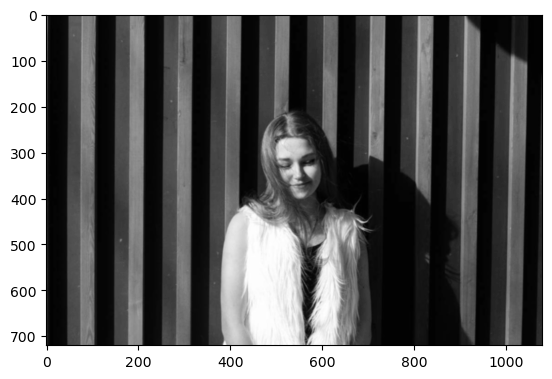

In [32]:
kernel = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]])
kernel = kernel/sum(kernel)
im_norm = image_normalization(im)
img = cv2.filter2D(im_norm,-1,kernel)
plt.imshow(img,cmap=plt.get_cmap('gray'))

## Результат похож

# Теперь займемся шумами ( используя Хаара )

In [33]:
def add_gaussian_noise(image, mean, variance, ratio):
    row,col = image.shape
    sigma = variance ** ratio
    gauss = np.random.normal(mean,sigma,(row,col))
    gauss = gauss.reshape(row,col)
    noisy = image + gauss
    noisy *= 255.0 / noisy.max() 
    noisy = np.clip(noisy, 0, 255)
    return noisy

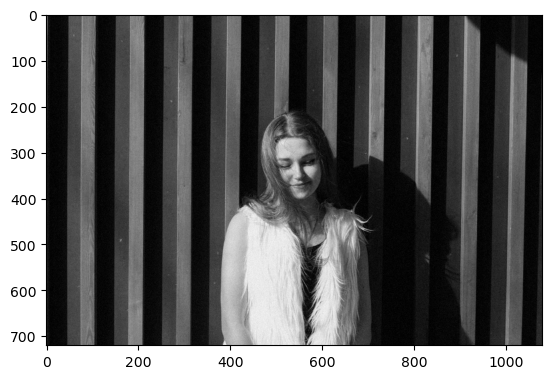

In [120]:
noisy = add_gaussian_noise(im,0,5,1)
plt.imshow(noisy,cmap=plt.get_cmap('gray'))

НЧ ФИЛЬТРАЦИЯ

312.05874061320316


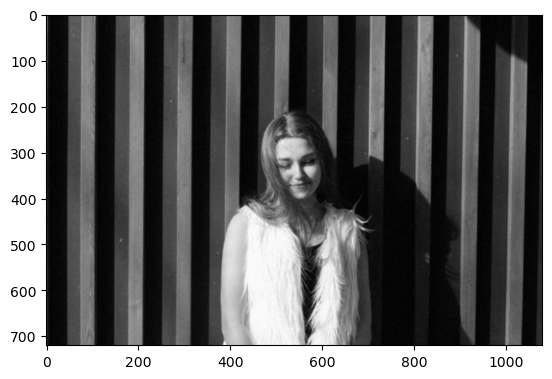

In [121]:
kernel = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1] ])
kernel = kernel/sum(kernel)
#im_norm = image_normalization(im)
img = cv2.filter2D(noisy,-1,kernel)
sko=sqrt(sum(sum((img-im)**2))/(512*512))
print(sko)
plt.imshow(img,cmap=plt.get_cmap('gray'))


a - approximation coefficients (LL)

h - horizontal detail coefficients (LH)

v - vertical detail coefficients (HL)

d - diagonal detail coefficients (HH)

## Я пробегаюсь по всем коэффициентам ( a , h,v,d,aa,ah,av,ad ,...) и делаю трэшхолд

In [38]:
from math import sqrt
import torch
from torch import numel

In [39]:
def noise_reduction_gauss(im , var , thresh):
    noisy = add_gaussian_noise(im,  0, var,1)
    wp = pywt.WaveletPacket2D(data=noisy, wavelet='haar')
    types = ['a', 'h', 'v', 'd']
    for d in range(0, 4):
        for i in range(4):    
            key_word = types[i] * d  
           # print(key_word)
            for j in range(4):
                key_word_inner = key_word + types[j]
                #print(key_word_inner)
                wp[key_word_inner].data = pywt.threshold(wp[key_word_inner].data, thresh, 'soft')
            if(key_word_inner == 'd'):
                break


    a = wp.reconstruct(update=False)
    plt.imshow(a,cmap=plt.get_cmap('gray'))
    sko=sqrt(sum(sum((im-a)**2))/(512*512))
    return(sko)

In [40]:
threshs = [ 1 , 5 , 10 , 15 , 20 ]
noise_5 = [0,0,0,0,0]
noise_10 = [0,0,0,0,0]
noise_20 = [0,0,0,0,0]

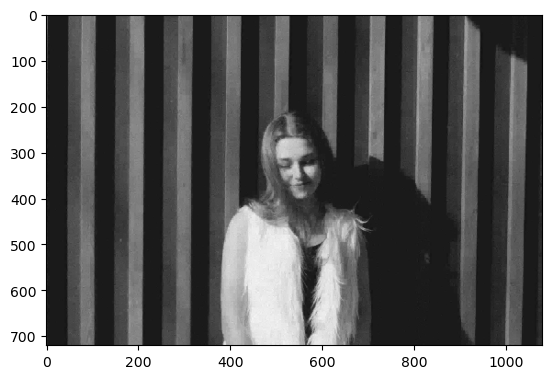

In [41]:
for i in range(5):
    noise_5[i] = noise_reduction_gauss(im , 5 , threshs[i]) 
    noise_10[i] = noise_reduction_gauss(im , 10 , threshs[i])
    noise_20[i] = noise_reduction_gauss(im , 20 , threshs[i])

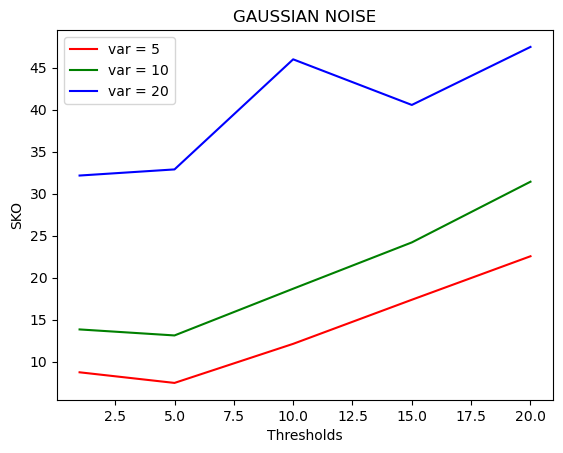

In [42]:
plt.plot(np.asarray(threshs), np.asarray(noise_5), color='r', label='var = 5')
plt.plot(np.asarray(threshs), np.asarray(noise_10), color='g', label='var = 10')
plt.plot(np.asarray(threshs), np.asarray(noise_20), color='b', label='var = 20')  

plt.xlabel("Thresholds")
plt.ylabel("SKO")
plt.title("GAUSSIAN NOISE")

plt.legend()

plt.show()

## Лучший результат

7.916909322213297

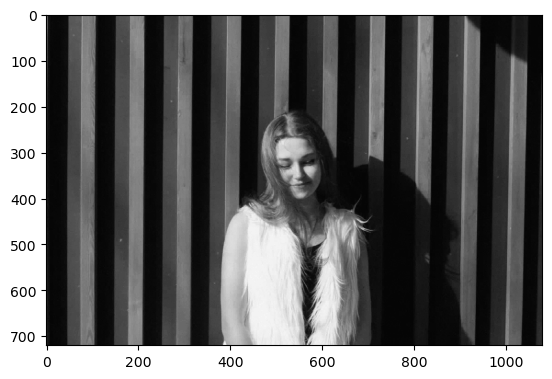

In [43]:
noise_reduction_gauss(im,5,5)

# Salt and Pepper noise

In [44]:
def add_salt_and_paper_noise(image, salt_ratio_paper, amount):
    row, col = image.shape
    out = np.copy(image)
    num_salt = np.ceil(amount * image.size * salt_ratio_paper)
    coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
    out[tuple(coords)] = 1
    num_pepper = np.ceil(amount * image.size * (1. - salt_ratio_paper))
    coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
    out[tuple(coords)] = 0
    out = np.clip(out, 0, 255)
    return out

In [89]:
def noise_reduction_sp(im , var , thresh):
    noisy = add_salt_and_paper_noise(im,  var, 0.01)
    wp = pywt.WaveletPacket2D(data=noisy, wavelet='haar')
    types = ['a', 'h', 'v', 'd']
    for d in range(0, 4):
        for i in range(4):    
            key_word = types[i] * d  
           # print(key_word)
            for j in range(4):
                key_word_inner = key_word + types[j]
                #print(key_word_inner)
                wp[key_word_inner].data = pywt.threshold(wp[key_word_inner].data, thresh, 'soft')
            if(key_word_inner == 'd'):
                break


    a = wp.reconstruct(update=False)
    plt.imshow(a,cmap=plt.get_cmap('gray'))
    sko=sqrt(sum(sum((im-a)**2))/(512*512))
    return(sko)

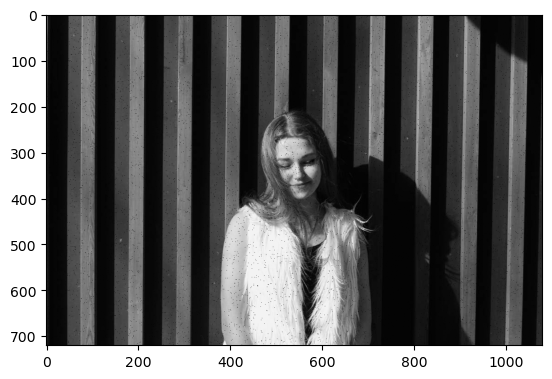

In [113]:
noisy = add_salt_and_paper_noise(im,  0.1, 0.01)
plt.imshow(noisy,cmap=plt.get_cmap('gray'))

In [93]:
threshs = [ 0.2 , 0.5 , 1 , 2,3,6,9  ]
noise_5 = [0,0,0,0,0,0,0]
noise_10 = [0,0,0,0,0,0,0]
noise_20 = [0,0,0,0,0,0,0]

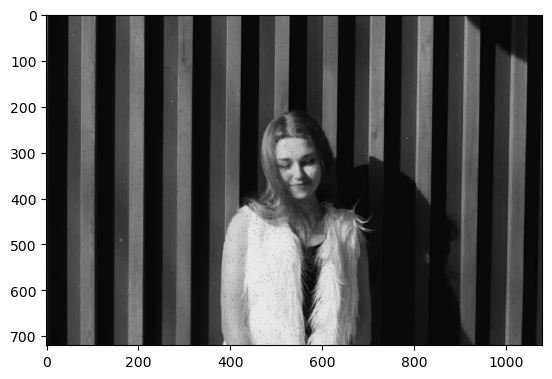

In [94]:
for i in range(7):
    noise_5[i] = noise_reduction_sp(im , 0.1 , threshs[i]) 
    noise_10[i] = noise_reduction_sp(im , 0.5 , threshs[i])
    noise_20[i] = noise_reduction_sp(im , 1 , threshs[i])

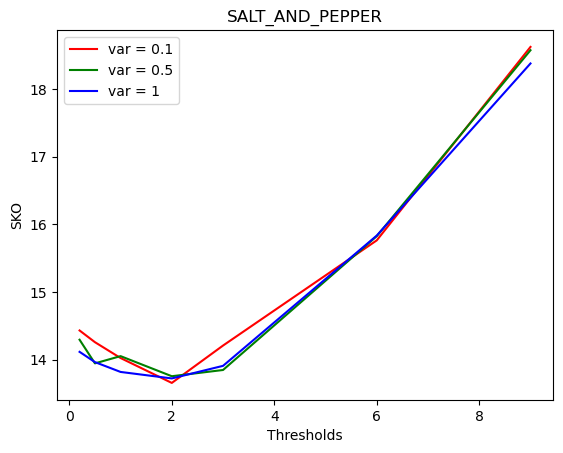

In [95]:
plt.plot(np.asarray(threshs), np.asarray(noise_5), color='r', label='var = 0.1')
plt.plot(np.asarray(threshs), np.asarray(noise_10), color='g', label='var = 0.5')
plt.plot(np.asarray(threshs), np.asarray(noise_20), color='b', label='var = 1')  

plt.xlabel("Thresholds")
plt.ylabel("SKO")
plt.title("SALT_AND_PEPPER")

plt.legend()

plt.show()

## Лучший результат

13.856365760952865

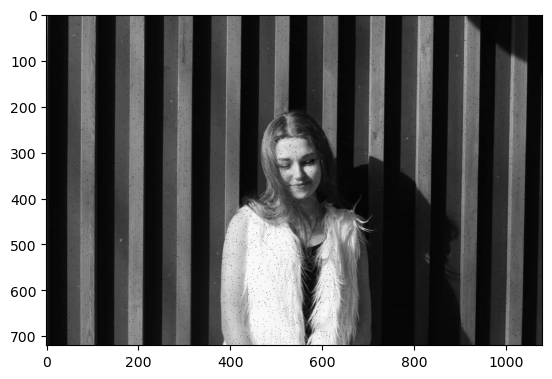

In [96]:
noise_reduction_sp(im,0.1,2)

142.80026061996045


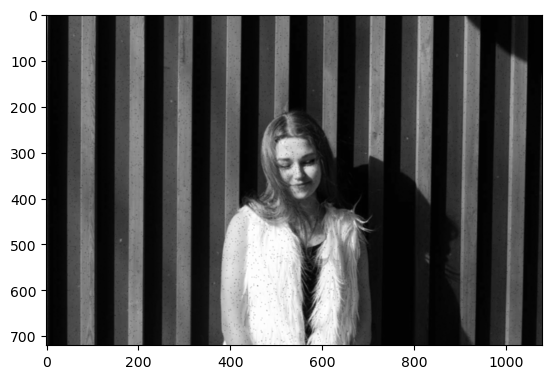

In [119]:
kernel = np.array([[1, 1,1], [1, 1,1], [1, 1,1]])
kernel = kernel/sum(kernel)
noisy1 = image_normalization(noisy)
img = cv2.filter2D(noisy1,-1,kernel)
sko=sqrt(sum(sum((img-im)**2))/(512*512))
print(sko)
plt.imshow(img,cmap=plt.get_cmap('gray'))

# Все :)